# Подключаем библиотеки

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
import seaborn as sns

<h3> Очистка данных

Записываем наши файлы в переменные, затем выводим виды колонок по каждому файлу.
train - для обучения модели
valid - для тестирования модели

In [2]:
data_train = pd.read_csv('train.csv', low_memory=False)
data_valid = pd.read_csv('valid.csv', low_memory=False)

numeric_columns = data_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_train.select_dtypes(include=['object']).columns
boolean_columns = data_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_valid.select_dtypes(include=['object']).columns
boolean_columns = data_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 2319
Категориальные колонки в train.csv: 347
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 2332
Категориальные колонки в valid.csv: 334
Булевые колонки в valid.csv: 0


Предобрабатываем данные:  
- Меняем тип данных у колонки `report_date` на `datetime` для создания временных признаков.  
- Добавляем 3 колонки:  
  - `days_since_last_report` — разница в днях между текущей и предыдущей датой для каждого клиента.  
  - `days_until_next_report` — количество дней до следующего отчета.  
  - `record_index` — накопительный счетчик записей для каждого клиента.  
- Удаляем низкокачественные столбцы, где менее 75% данных заполнено.  
- Заполняем пропуски на уровне клиента методами `ffill` и `bfill`, чтобы сохранить временную структуру.  
- Удаляем дубликаты записей.  
- Заполняем числовые пропуски медианой в числовых колонках.  
- Приводим структуру валидационных данных в соответствие с тренировочными.  
- Сравниваем количество колонок и строк до и после обработки.

In [4]:
# Преобразование дат в формат datetime
def preprocess_dates(data):
    if 'report_date' in data.columns:
        data['report_date'] = pd.to_datetime(data['report_date'], errors='coerce')
    return data

# Создание временных признаков
def create_time_features(data):
    # Упорядочиваем данные по client_id и report_date
    data = data.sort_values(['client_id', 'report_date'])
    
    # Разница в днях между текущей и предыдущей датой для каждого клиента
    data['days_since_last_report'] = data.groupby('client_id')['report_date'].diff().dt.days.fillna(0)
    
    # Количество дней до следующего отчета (где возможно)
    data['days_until_next_report'] = data.groupby('client_id')['report_date'].diff(-1).dt.days.fillna(0)
    
    # Накопительный счетчик записей для каждого клиента
    data['record_index'] = data.groupby('client_id').cumcount() + 1
    
    return data

# Обработка пропусков без потери временной структуры
def fill_missing_values(data):
    # Заполняем пропуски только в пределах клиента
    data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
    return data

# Удаление колонок с низким качеством данных
def drop_low_quality_columns(data, threshold=0.75):
    # Удаление колонок, где все значения NaN
    data = data.dropna(axis=1, how='all')
    
    # Удаление колонок, где менее 75% данных заполнено
    data = data.loc[:, (data.notna()).mean() > threshold]
    return data

# Основной пайплайн обработки данных
def process_data(data, skip_drop_col):
    # Преобразуем даты
    data = preprocess_dates(data)
    
    # Добавляем временные признаки
    data = create_time_features(data)

    if skip_drop_col:
        # Удаляем низкокачественные столбцы
        data = drop_low_quality_columns(data)
        # # Удаляем строки, где менее 75% данных заполнено
        # data = data[data.notna().mean(axis=1) > 0.75]

    # Заполняем пропуски на уровне клиента
    data = fill_missing_values(data)
    
    # Удаляем дубликаты
    data = data.drop_duplicates()
    
    return data

# Применение обработки к train и valid
data_cleaned_train = process_data(data_train, True)
data_cleaned_valid = process_data(data_valid, False)

# Приведение колонок valid к train (если в train остались неиспользуемые колонки)
data_cleaned_valid = data_cleaned_valid[data_cleaned_train.columns]
# data_cleaned_valid = data_cleaned_valid[data_cleaned_valid.notna().mean(axis=1) > 0.75]

# Работа с числовыми столбцами: заполнение медианой
numeric_columns_train = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
numeric_columns_valid = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns

imputer = SimpleImputer(strategy='median')
data_cleaned_train[numeric_columns_train] = imputer.fit_transform(data_cleaned_train[numeric_columns_train])
data_cleaned_valid[numeric_columns_valid] = imputer.transform(data_cleaned_valid[numeric_columns_valid])

# Сравнение до и после обработки
print(f"До удаления колонок (train.csv): {data_train.shape[1]} колонок")
print(f"После удаления колонок (train.csv): {data_cleaned_train.shape[1]} колонок")
print(f"Число строк до удаления (train.csv): {data_train.shape[0]}")
print(f"Число строк после удаления (train.csv): {data_cleaned_train.shape[0]}\n")
print(f"До удаления колонок (valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок (valid.csv): {data_cleaned_valid.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {data_cleaned_valid.shape[0]}")


C:\Users\artem\AppData\Local\Temp\ipykernel_12736\1449868947.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\artem\AppData\Local\Temp\ipykernel_12736\1449868947.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\artem\AppData\Local\Temp\ipykernel_12736\1449868947.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

До удаления колонок (train.csv): 2666 колонок
После удаления колонок (train.csv): 250 колонок
Число строк до удаления (train.csv): 14456
Число строк после удаления (train.csv): 14456

До удаления колонок (valid.csv): 2666 колонок
После удаления колонок (valid.csv): 250 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 3642


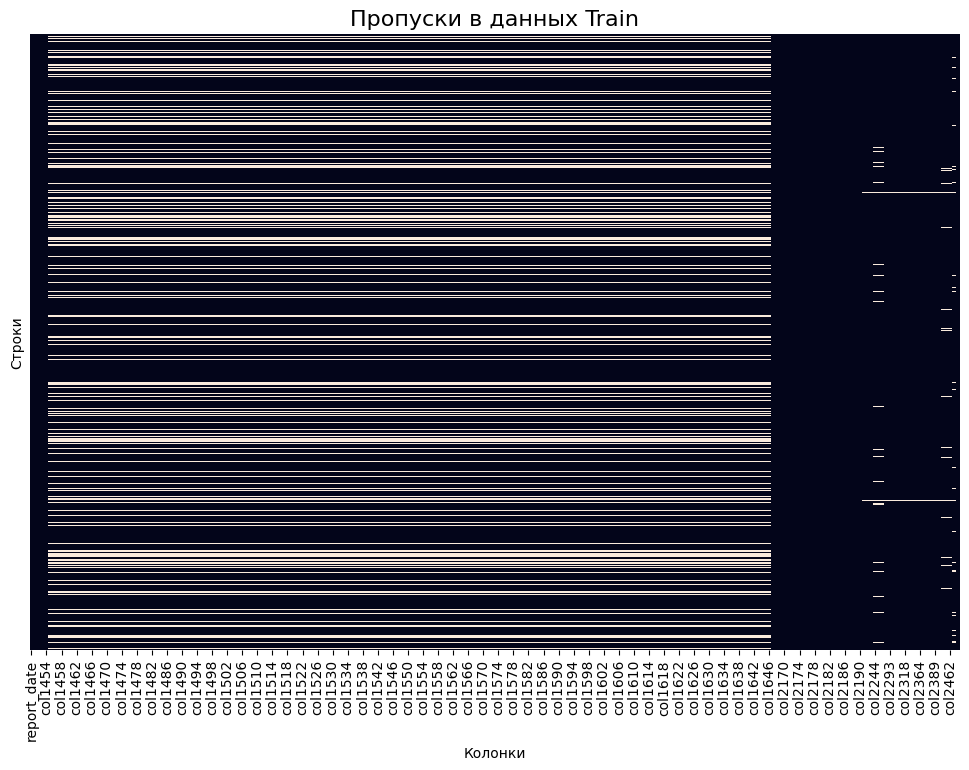

In [20]:
vis_data = data_cleaned_train.copy()
vis_data = vis_data.drop(columns=['days_since_last_report', 'days_until_next_report', 'record_index'])

# Визуализация пропусков в train
plt.figure(figsize=(12, 8))
sns.heatmap(data_train[vis_data.columns].isnull(), cbar=False, yticklabels=False)
plt.title("Пропуски в данных Train", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

In [9]:
data_cleaned_train.head()

report_date  client_id  target  col1453  \
client_id                                                 
1         12132  2021-10-01        1.0     0.0      0.0   
          4718   2021-12-01        1.0     0.0      0.0   
          6471   2022-06-01        1.0     0.0      0.0   
          0      2022-11-01        1.0     0.0      0.0   
2         13554  2022-06-01        2.0     0.0      0.0   

                                              col1454  col1455  col1456  \
client_id                                                                 
1         12132  00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          4718   00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          6471   00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
          0      00f3d719-a6ec-4960-ba01-8372eb705443      0.0      0.0   
2         13554  01016bd5-10dc-ec11-b823-005056b825cd      1.0      1.0   

                 col1457  col1458  col1459  ...  col2389  col2390  col2460  \
client_id                                   ...                              
1         12132      0.0      0.0      1.0  ...    37.88    37.88      0.0   
          4718       0.0      0.0      1.0  ...    37.88    37.88      0.0   
          6471       0.0      0.0      1.0  ...    37.88    37.88      0.0   
          0          0.0      0.0      0.0  ...    37.88    37.88      0.0   
2         13554      1.0      1.0      1.0  ...    30.09    30.09      1.7   

                 col2461  col2462  col2470   col2663  days_since_last_report  \
client_id                                                                      
1         12132      0.0      0.0    146.0  0.256261                     0.0   
          4718       0.0      0.0    209.0  0.256261                    61.0   
          6471       0.0      0.0    391.0  0.256261                   182.0   
          0          0.0      0.0    545.0  0.256261                   153.0   
2         13554      1.7      1.7    152.0  0.256919                     0.0   

                 days_until_next_report  record_index  
client_id                                              
1         12132                   -61.0           1.0  
          4718                   -182.0           2.0  
          6471                   -153.0           3.0  
          0                         0.0           4.0  
2         13554                  -153.0           1.0  

[5 rows x 250 columns]

In [5]:
numeric_columns = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_cleaned_train.select_dtypes(include=['object']).columns
boolean_columns = data_cleaned_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_cleaned_valid.select_dtypes(include=['object']).columns
boolean_columns = data_cleaned_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 248
Категориальные колонки в train.csv: 1
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 248
Категориальные колонки в valid.csv: 1
Булевые колонки в valid.csv: 0


In [11]:
data_cleaned_valid[categorical_columns]

col1454
client_id                                           
2         2326  01016bd5-10dc-ec11-b823-005056b825cd
          0     01016bd5-10dc-ec11-b823-005056b825cd
4         506   0151dccf-0ecb-ed11-b828-005056b81dee
          1     0151dccf-0ecb-ed11-b828-005056b81dee
5         428   01febac0-b083-494e-8589-f98400074b94
...                                              ...
8277      3620  b459bb54-0eb2-ed11-b824-005056b8a6c4
8286      3629  c7027830-9969-ed11-b824-005056b89b68
8292      3633  d8fd10d1-88cb-ec11-b822-005056b8a6d9
8298      3638  f44867e9-7bbe-4ccd-8711-673023bd8a41
8300      3640  f7f49246-171a-ed11-b823-005056b8a72c

[3642 rows x 1 columns]

### Сохраняем очищенные данные

In [6]:
data_cleaned_train.to_csv('cleaned_train.csv', index=False)
data_cleaned_valid.to_csv('cleaned_valid.csv', index=False)

# Подготовка данных для обучения
Рассмотрим баланс классов в `train`

Баланс классов в целевой переменной:
target
0.0    0.96984
1.0    0.03016
Name: proportion, dtype: float64


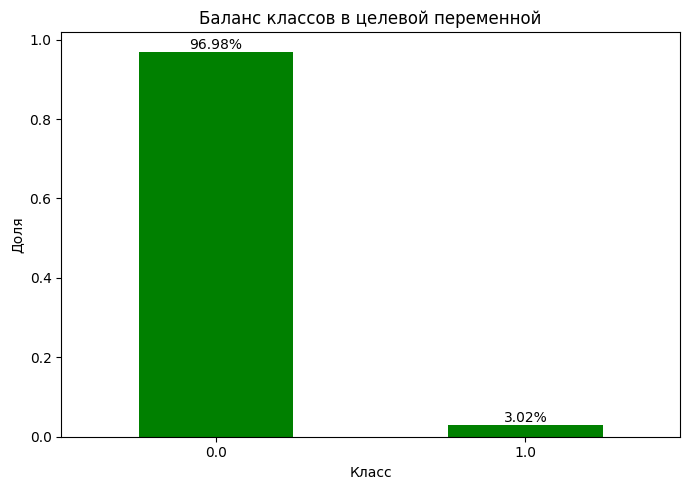

In [7]:
numeric_df_train = data_cleaned_train.drop(columns=["report_date", "col1454"])
numeric_df_valid = data_cleaned_valid.drop(columns=["report_date", "col1454"])
# Пример (должны быть признаки и целевая переменная)
X_train = numeric_df_train.drop(columns=['target', 'client_id'])  # Признаки
y_train = data_cleaned_train['target']                # Целевая переменная

# Вывод баланса классов для целевой переменной
class_balance = y_train.value_counts(normalize=True)
print("Баланс классов в целевой переменной:")
print(class_balance)

# Визуализация баланса классов
plt.figure(figsize=(7, 5))
class_balance.plot(kind='bar', color='green')
plt.title('Баланс классов в целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Производим балансировку классов в `train` с помощью алгоритма `SMOTETomek`, затем выводим график баланса классов

d:\project\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
d:\project\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
d:\project\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate

Баланс после SMOTE:
target
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


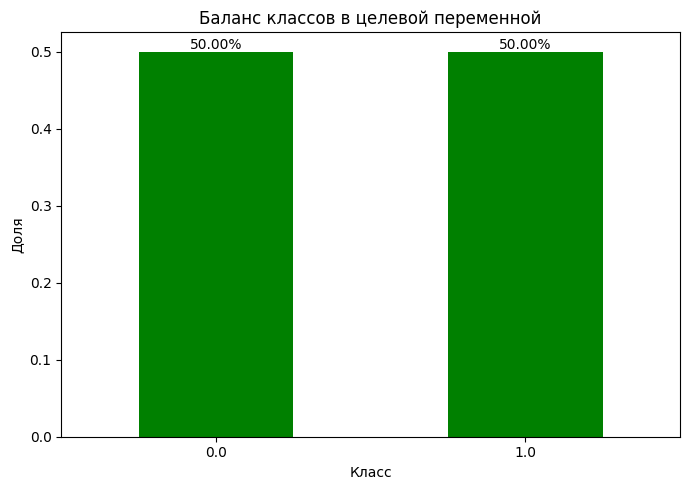

In [8]:
# Создаем объект SMOTE
smote = SMOTETomek(random_state=42)

# Применяем SMOTE
X_balanced_train, y_balanced_train = smote.fit_resample(X_train, y_train)

class_balance = y_balanced_train.value_counts(normalize=True)

# Проверяем баланс
print("Баланс после SMOTE:")
print(y_balanced_train.value_counts(normalize=True))
# Визуализация баланса классов
plt.figure(figsize=(7, 5))
class_balance.plot(kind='bar', color='green')
plt.title('Баланс классов в целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Производим выборку важных признаков при помощи PCA

In [9]:
# 1. Масштабирование данных для PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced_train)

# 2. Применяем PCA
pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_pca = pca.fit_transform(X_scaled)

# 3. Определяем вклад признаков в каждую компоненту
components = pd.DataFrame(pca.components_, columns=X_balanced_train.columns)

# 4. Определяем признаки, наиболее влияющие на компоненты
important_features = set()
threshold = 0.25  # Порог значимости вклада признака
for component in components.values:
    feature_contributions = np.abs(component)  # Берем абсолютные значения вкладов
    important_features.update(X_balanced_train.columns[feature_contributions > threshold])

# 5. Сохраняем важные признаки в отдельную переменную
important_features = list(important_features)
X_selected = X_balanced_train[important_features]

print("Количество важных признаков:", len(important_features))
print("Важные признаки:", important_features)

Количество важных признаков: 83
Важные признаки: ['col2186', 'col2365', 'col2460', 'col1453', 'col1524', 'col2167', 'col1474', 'col1468', 'col2171', 'col1503', 'days_until_next_report', 'col2388', 'col2244', 'col1514', 'col2462', 'col1526', 'col2317', 'col1521', 'col2663', 'col1499', 'col1470', 'col2246', 'col1462', 'col1477', 'col2293', 'col2188', 'col1476', 'col2342', 'col1487', 'col1455', 'col2182', 'col1460', 'col1523', 'col1471', 'col1525', 'col2292', 'col2389', 'col1515', 'col2390', 'col1504', 'col1522', 'col1498', 'col1511', 'col2175', 'col1467', 'col1472', 'days_since_last_report', 'col1459', 'col2341', 'col1492', 'col2245', 'col1496', 'record_index', 'col1500', 'col2221', 'col1497', 'col1505', 'col1502', 'col1475', 'col1520', 'col1507', 'col2222', 'col2178', 'col1473', 'col1509', 'col1506', 'col1510', 'col1495', 'col2461', 'col2183', 'col2366', 'col1501', 'col2181', 'col1494', 'col2184', 'col2470', 'col1513', 'col1491', 'col1478', 'col2187', 'col1463', 'col2294', 'col1508']


In [16]:
X_balanced_train[important_features].head()

,col1496,col2389,col1509,col2167,col2461,col2462,col1525,record_index,col1524,col1463,...,col1470,col1472,col1522,col2184,col1460,col2294,col1502,col1503,days_until_next_report,col2341
0,0.0,37.88,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,-61.0,6801884.32
1,0.0,37.88,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,-182.0,6801884.32
2,0.0,37.88,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,-153.0,6801884.32
3,0.0,37.88,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,6801884.32
4,0.0,30.09,0.0,1.0,1.7,1.7,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,-153.0,5794341.03


<h3> Тестируем модель

Делаем подбор оптимальных параметров для модели `RandomForest`

In [17]:
rf = RandomForestClassifier(random_state=42)
X_train = X_balanced_train[important_features]
y_train = y_balanced_train
X_test = numeric_df_valid.drop(columns=['client_id', 'target'])[important_features]
y_test = data_cleaned_valid['target']

# Сужаем диапазоны для более точного поиска
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', "balanced_subsample"]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Оценка на тестовых данных
best_rf = grid_search.best_estimator_
y_pred_test = best_rf.predict(X_test)
y_pred_proba_test = best_rf.predict_proba(X_test)[:, 1]

# Метрики
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1-score:", f1_score(y_test, y_pred_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_test))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Лучшие параметры: {'class_weight': 'balanced_subsample', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.9810543657331137
F1-score: 0.1038961038961039
ROC-AUC: 0.8110721307030032


## Тестируем модель `RandomForest`

In [10]:
X_train = X_balanced_train[important_features]
y_train = y_balanced_train
X_test = numeric_df_valid.drop(columns=['client_id', 'target'])[important_features]
y_test = data_cleaned_valid['target']

# Пайплайн для RandomForest
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(
        random_state=42, 
        class_weight='balanced_subsample', 
        max_depth=50, 
        max_features='log2', 
        min_samples_leaf=1, 
        min_samples_split=2, 
        n_estimators=500))
])

# RandomForest
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_rf_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("Метрики для RandomForest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf_prob))
print(classification_report(y_test, y_pred_rf))

Метрики для RandomForest:
Accuracy: 0.9810543657331137
F1-score: 0.1038961038961039
ROC-AUC: 0.8128431970713851
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3576
         1.0       0.36      0.06      0.10        66

    accuracy                           0.98      3642
   macro avg       0.67      0.53      0.55      3642
weighted avg       0.97      0.98      0.97      3642



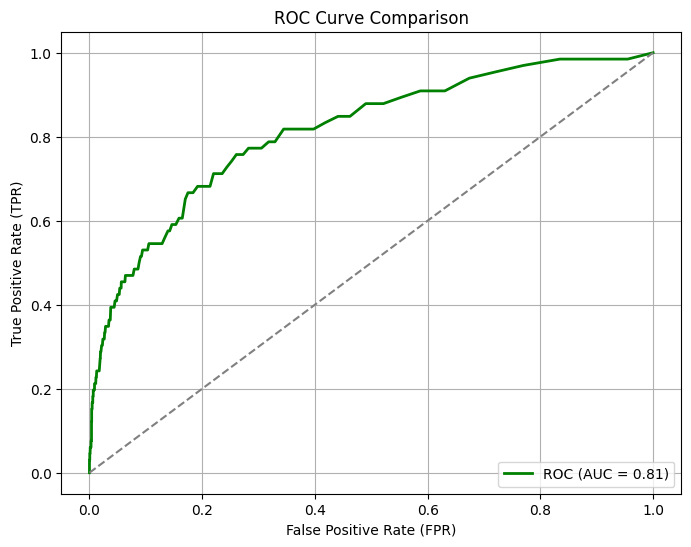

In [11]:
# Предсказания для модели RandomForest
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_reduced = roc_auc_score(y_test, y_pred_rf_prob)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_reduced, tpr_reduced, color='green', lw=2, label=f'ROC (AUC = {roc_auc_reduced:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Тестируем модель `LightGBM`

[LightGBM] [Info] Number of positive: 13984, number of negative: 13984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13657
[LightGBM] [Info] Number of data points in the train set: 27968, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Метрики для LightGBM:
Accuracy: 0.9785831960461285
F1-score: 0.23529411764705882
ROC-AUC: 0.8475399972883194
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3576
         1.0       0.33      0.18      0.24        66

    accuracy                           0.98      3642
   macro avg       0.66      0.59      0.61      3642
weighted avg       0.97      0.98      0.98      3642



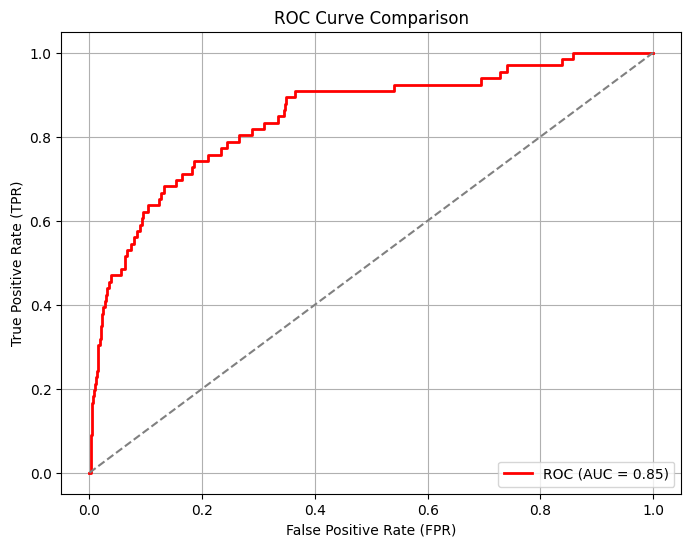

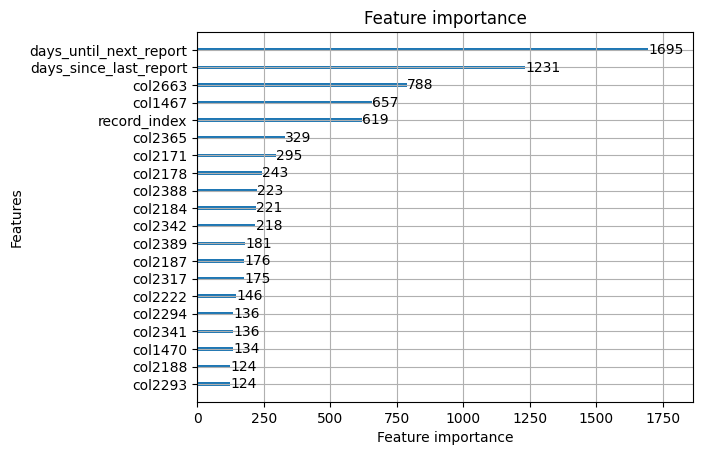

In [13]:
lgb_model = LGBMClassifier(boosting_type='gbdt',
    objective='binary',
    class_weight='balanced',
    learning_rate=0.01, n_estimators=500, num_leaves=20, min_child_samples=30, random_state=42)

test_col = ["col2663", "col2470", "col2317", "col2342", "col2388", "col2389", "col2292", "col2294", "col2461", "col2460", "col2390", "days_since_last_report", "col2293", "record_index", "days_until_next_report"]
# Оценка моделей

    # Обучение модели
lgb_model.fit(X_train, y_train)
# Предсказания
y_pred = lgb_model.predict(X_test)
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# Создаем файл submission_file.csv
submission = pd.DataFrame({
    'client_id': numeric_df_valid['client_id'],  # Используем client_id из тестового набора
    'score': y_pred_prob  # Вероятности, предсказанные моделью
})

# Сохраняем результат в CSV
submission.to_csv('submission_file.csv', index=False)

# Метрики
print(f"Метрики для LightGBM:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_pred_prob)
roc_auc_reduced = roc_auc_score(y_test, y_pred_prob)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_reduced, tpr_reduced, color='red', lw=2, label=f'ROC (AUC = {roc_auc_reduced:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plot_importance(lgb_model, max_num_features=20)
plt.show()

## Тестируем модель `xgboost`

Метрики для XGBoost:
Accuracy: 0.9802306425041186
F1-score: 0.21739130434782608
ROC-AUC: 0.8465951460917904
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3576
         1.0       0.38      0.15      0.22        66

    accuracy                           0.98      3642
   macro avg       0.68      0.57      0.60      3642
weighted avg       0.97      0.98      0.98      3642



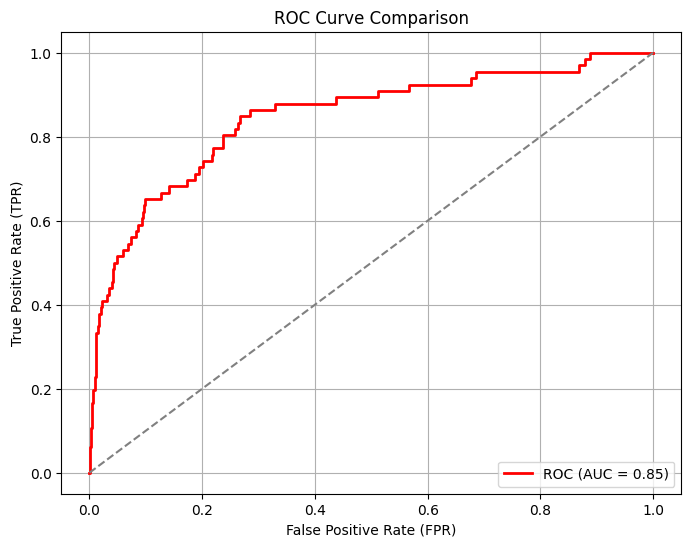

In [31]:
xgb_model = XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train == 1), 
                        random_state=42,
                        eval_metric='logloss',
                        max_depth=30,
                        n_estimators=500,
                        learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Метрики для XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_xgb))
print(classification_report(y_test, y_pred_xgb))

fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_reduced = roc_auc_score(y_test, y_pred_prob_xgb)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_reduced, tpr_reduced, color='red', lw=2, label=f'ROC (AUC = {roc_auc_reduced:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Вывод по тестам моделей:

1. **RandomForest**:
   - **Accuracy**: 0.9810 (высокая, но это ожидаемо при дисбалансе классов).
   - **F1-score**: 0.1039 (низкое качество для класса 1, модель плохо справляется с выявлением положительного класса).
   - **ROC-AUC**: 0.8111 (средний показатель, указывающий на ограниченную способность модели разделять классы).
   - Модель сильно склоняется в сторону класса 0, давая высокую точность, но низкую полноту и F1 для класса 1.

2. **LightGBM**:
   - **Accuracy**: 0.9786 (похожий уровень на RandomForest, но чуть ниже).
   - **F1-score**: 0.2353 (значительно лучше, чем у RandomForest, для класса 1).
   - **ROC-AUC**: 0.8475 (наилучший показатель среди всех моделей, что говорит о лучшей способности разделять классы).
   - **Вывод**: модель немного лучше справляется с обнаружением класса 1, имеет сбалансированный результат между precision и recall.

3. **XGBoost**:
   - **Accuracy**: 0.9800 (на уровне RandomForest).
   - **F1-score**: 0.1978 (хуже, чем у LightGBM, но лучше RandomForest).
   - **ROC-AUC**: 0.8462 (сопоставимо с LightGBM, что говорит о схожем уровне дискриминации классов).
   - Модель даёт лучшие precision, чем LightGBM, но хуже recall, что влияет на общий F1.

---

### Общий вывод:
- **LightGBM** показала лучший компромисс между recall и precision для класса 1. С учетом цели минимизация ложных срабатываний, LightGBM выглядит наиболее подходящей для кейса.
- **RandomForest** показывает слабые результаты для класса 1, что делает его менее подходящим для анализа положительных событий.
- **XGBoost** также демонстрирует высокий accuracy, но уступает LightGBM по F1 и ROC-AUC, поэтому является вторым по предпочтению вариантом.